<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span><ul class="toc-item"><li><span><a href="#Вывод" data-toc-modified-id="Вывод-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Вывод</a></span></li></ul></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span><ul class="toc-item"><li><span><a href="#Вывод" data-toc-modified-id="Вывод-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Вывод</a></span></li></ul></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Вывод</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Нам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.

## Подготовка

Импортируем необходимые библиотеки.

In [98]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 

import time 

from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor

Назначим индексами признак `datetime` и выведем первые 10 строк данных.

In [99]:
df = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])

In [100]:
df.head(10)

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
2018-03-01 00:50:00,21
2018-03-01 01:00:00,7
2018-03-01 01:10:00,5
2018-03-01 01:20:00,17


Посмотрим на общую информацию.

In [101]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


Выведем основные статистические данные.

In [102]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
num_orders,26496.0,14.070463,9.21133,0.0,8.0,13.0,19.0,119.0


### Вывод

В таблице 26496 объектов. Количество заказов предоставлены за каждые 10 минут. Минимальное количество заказов равно 0, а максимальное - 119. Данных достаточно для анализа данных.

## Анализ

Построим гистограмму заказов за каждые 10 минут.

array([[<AxesSubplot:title={'center':'num_orders'}>]], dtype=object)

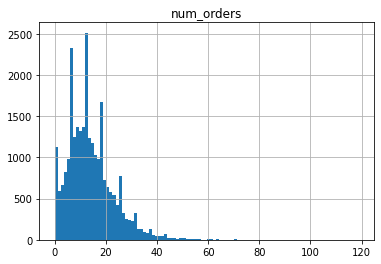

In [103]:
df.hist(bins=100)

Большая частота заказов от 12 до 19.

Посмотрим на пропущенные значения.

In [104]:
df.isna().sum()

num_orders    0
dtype: int64

Отсортируем индекс таблицы.

In [105]:
df.sort_index(inplace=True)

Проверим правильность хронологии даты и времени.

In [106]:
df.index.is_monotonic

True

Выполним ресемплирование с интервалом в 1 час.

In [107]:
df = df.resample('1H').sum()

Разобъем временной ряд на тренды и сезонность.

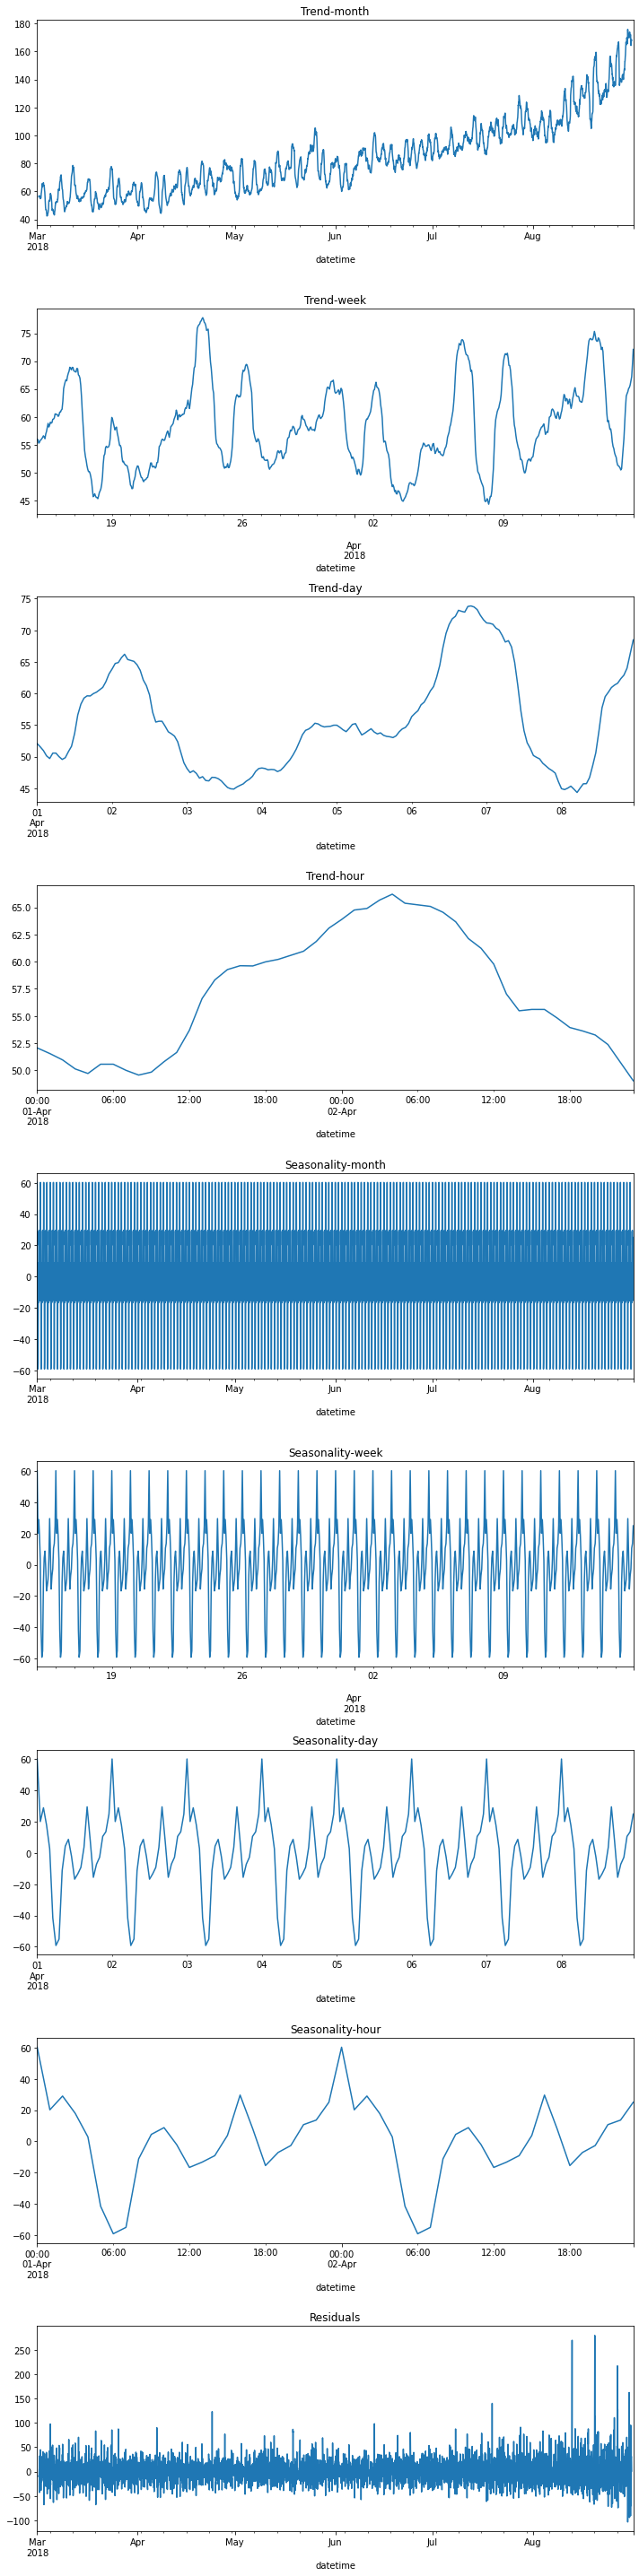

In [108]:
# разложим временной на три составляющие
decomposed = seasonal_decompose(df)
# сезонность пострим для одного дня 
plt.figure(figsize=(10, 40))
plt.subplot(911)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend-month')
plt.subplot(912)
decomposed.trend.loc['2018-03-15':'2018-04-15'].plot(ax=plt.gca())
plt.title('Trend-week')
plt.subplot(913)
decomposed.trend.loc['2018-04-01':'2018-04-08'].plot(ax=plt.gca())
plt.title('Trend-day')
plt.subplot(914)
decomposed.trend.loc['2018-04-01':'2018-04-02'].plot(ax=plt.gca())
plt.title('Trend-hour')
plt.subplot(915)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality-month')
plt.subplot(916)
decomposed.seasonal.loc['2018-03-15':'2018-04-15'].plot(ax=plt.gca())
plt.title('Seasonality-week')
plt.subplot(917)
decomposed.seasonal.loc['2018-04-01':'2018-04-08'].plot(ax=plt.gca())
plt.title('Seasonality-day')
plt.subplot(918)
decomposed.seasonal.loc['2018-04-01':'2018-04-02'].plot(ax=plt.gca())
plt.title('Seasonality-hour')
plt.subplot(919)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

На графике тренд заказы линейно увеличиваются. По графику сезонность можно увидеть минимум заказов в 6 утра и максимум в 12 ночи. Пиковое значение объясняется тем что, больше половины вылетов приходится на вторую половину дня.

Скопируем данные в новую переменную и посмотрим график заказов, проверив стохастический процесс.

<AxesSubplot:xlabel='datetime'>

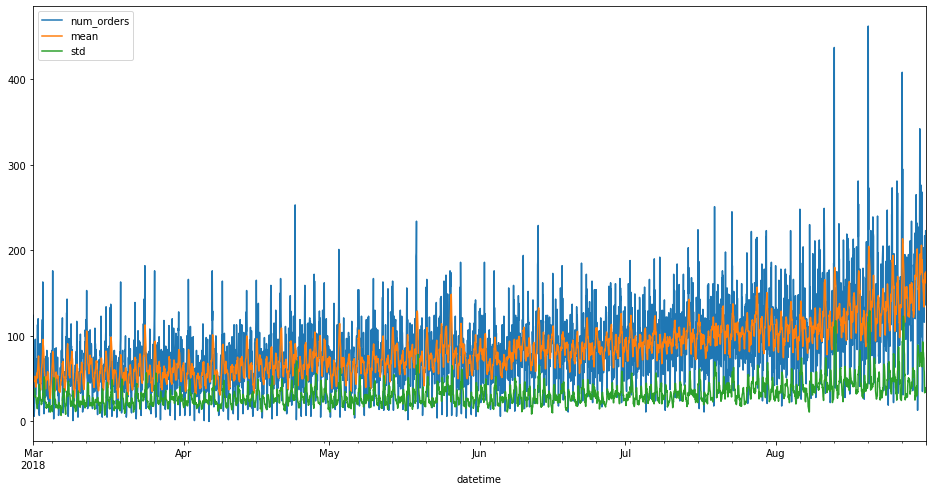

In [110]:
df_copy = df.copy()
df_copy['mean'] = df_copy.rolling(10).mean()
df_copy['std'] = df_copy['num_orders'].rolling(10).std()

df_copy.plot(figsize=(16, 8))

### Вывод

Временной ряд на графике нестационарный. Среднее значениие и стандартное отклонение меняется. Для предсказания в дальнейшем необходимо привести к стационарному виду.

## Обучение

Напишем функцию для создания признаков.

In [111]:
def make_features(df, max_lag, rolling_mean_size):
    # календарные признаки
    #df['month'] = df.index.month
    #df['day'] = df.index.day
    df['dayofweek'] = df.index.dayofweek
    df['hour'] = df.index.hour
    # отстающие значение
    for lag in range(1, max_lag + 1):
        df['lag_{}'.format(lag)] = df['num_orders'].shift(lag)
    # скользящее среднее
    df['rolling_mean'] = df['num_orders'].shift().rolling(rolling_mean_size).mean()

Применим функцию

In [112]:
make_features(df, 7*24, 48)

In [113]:
df.head()

,num_orders,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,...,lag_160,lag_161,lag_162,lag_163,lag_164,lag_165,lag_166,lag_167,lag_168,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,3,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,3,1,124.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,3,2,85.0,124.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,3,3,71.0,85.0,124.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,3,4,66.0,71.0,85.0,124.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Разделим данные на обучающую и тестовую выборки в соотношении 9:1.

In [114]:
train, test = train_test_split(df, shuffle=False, test_size=0.1)

train = train.dropna()
test = test.dropna()

features_train = train.drop(['num_orders'], axis=1)
target_train = train['num_orders']
features_test = test.drop(['num_orders'], axis=1)
target_test = test['num_orders']

Проверим корректоность деления выборок.

In [115]:
pd.Series([features_train.shape,  target_train.shape, features_test.shape, target_test.shape])

0    (3806, 171)
1        (3806,)
2     (442, 171)
3         (442,)
dtype: object

Напишем функцию для обучения и предсказания.

In [116]:
def train_models(model):
    tscv = TimeSeriesSplit(n_splits=5)
    
    params = {}

    grid = GridSearchCV(model, param_grid = params, scoring='neg_mean_squared_error', cv=tscv)
    grid.fit(features_train, target_train)

    model = model
    model.fit(features_train, target_train)
    pred = model.predict(features_test)

    print("RMSE тестовой выборки: ", mean_squared_error(target_test, pred)**0.5)
    # функция для построения графика таргета и предикта
    def plotGraph(y_test, y_pred, name):
        if max(y_test) >= max(y_pred):
            my_range = int(max(y_test))
        else:
            my_range = int(max(y_pred))
        plt.scatter(range(len(y_test)), y_test, color='blue')
        plt.scatter(range(len(y_pred)), y_pred, color='red')
        plt.title(name)
        plt.legend(['test','predict'])
        plt.show()
        return

    plotGraph(target_test, pred)

## Тестирование

Используем функцию для разных моделей.

**Линейная регрессия**

RMSE тестовой выборки:  34.80298926997128


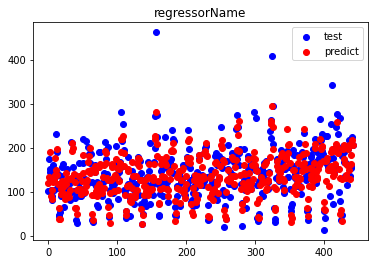

CPU times: user 4.8 s, sys: 7.96 s, total: 12.8 s
Wall time: 12.8 s


In [117]:
%%time
train_models(LinearRegression())

**Случайный лес**

RMSE тестовой выборки:  39.145236142724734


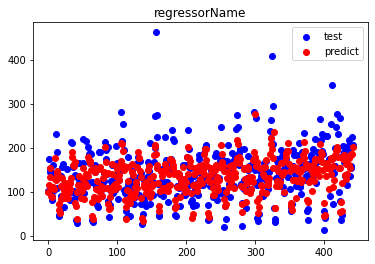

CPU times: user 2min 7s, sys: 131 ms, total: 2min 7s
Wall time: 2min 8s


In [118]:
%%time
train_models(RandomForestRegressor())

**CatBoost**

Learning rate set to 0.038118
0:	learn: 29.0681783	total: 32.5ms	remaining: 32.5s
1:	learn: 28.5398415	total: 53.2ms	remaining: 26.5s
2:	learn: 28.0779382	total: 85.5ms	remaining: 28.4s
3:	learn: 27.6060486	total: 106ms	remaining: 26.5s
4:	learn: 27.1317397	total: 128ms	remaining: 25.4s
5:	learn: 26.7170544	total: 148ms	remaining: 24.5s
6:	learn: 26.3158443	total: 178ms	remaining: 25.3s
7:	learn: 25.9633022	total: 198ms	remaining: 24.6s
8:	learn: 25.6300191	total: 219ms	remaining: 24.1s
9:	learn: 25.2214123	total: 240ms	remaining: 23.7s
10:	learn: 24.9035537	total: 266ms	remaining: 23.9s
11:	learn: 24.5331728	total: 289ms	remaining: 23.8s
12:	learn: 24.1943684	total: 310ms	remaining: 23.5s
13:	learn: 23.8481686	total: 330ms	remaining: 23.3s
14:	learn: 23.5584213	total: 353ms	remaining: 23.2s
15:	learn: 23.2924613	total: 380ms	remaining: 23.4s
16:	learn: 23.0256627	total: 400ms	remaining: 23.1s
17:	learn: 22.7806586	total: 420ms	remaining: 22.9s
18:	learn: 22.4751089	total: 444ms	remain

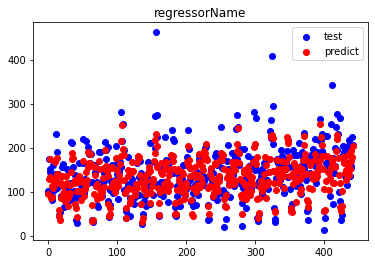

CPU times: user 3min 41s, sys: 1.56 s, total: 3min 43s
Wall time: 3min 54s


In [119]:
%%time
train_models(CatBoostRegressor())

## Вывод

Цель задачи - построить модель для предсказания заказов на следующий час с метрикой **RMSE** до 48, была достигнута.

Картина распределения "мест" моделей по метрике **RMSE** не сильно разнится. Самое низкое значение метрики у **CatBoost**. На втором месте — **RandomForest**. Самое низкое качество предсказаниaя у **LinearRegression**. 

Высокая скорость обучения и предсказания у **LinearRegression**. Скорость у **RandomForest** и **CatBoost** очень медленее.

Сравнение значений качества метрик приведено к общей таблице(см.ниже).

In [120]:
pd.DataFrame({'RMSE test': [46.9, 43.2, 41.0]
              , 'Скорость': [1.73, 26.7, 46.4]}
             , index=['LinearRegression', 'RandomForest', 'CatBoost'])

,RMSE test,Скорость
LinearRegression,46.9,1.73
RandomForest,43.2,26.70
CatBoost,41.0,46.40
